In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
from tabulate import tabulate
from calendar import monthrange
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker
from calendar import monthrange
import locale
import sys
sys.path.insert(0,'../src')
import file_import
from pickle import load
from datetime import date
import statsmodels.api as sm
import statsmodels.stats.power as smp
from scipy.stats import norm

pull out am and pm, pull out just Assaults that Domestic Violence Yes or No
from the assaults how many have domesitic violence
can we use this other iformation based on location can we use other columsn to help determine if these things will affect getting arresting
if there is assault and subset by domestic, predict 

ask for all crimes for domestic

step: have assault DF
### cut out? 2) pull out domestic violence = yes 
3) for all variables that are categrotical, use get dummies to get 1s 0s 
4) drop one of the columns for every one of the get dummies (most common)
5) is theft   is murder  is narcotic
     1           0            0
     0           1            0
     0           0            1
6) after get dummies drop column that is most common, the one with the most ones drop it
7) arrest = y x = use all other useful columns as features, drop the uncessary ones like ID, Case number, IUCR, ward, community area, coordinates, updated on, beat, fbi code
8) identify y and x values
9) train,test,split I will need help
9) perform logic regression and fit on training values with target being y values which arrest
11) after fit use x test values to get new predictions for y and see how well your model predicted your values
12) from model get coef and that will help determine which column had the strongest effect if something resulted in arrest

In [2]:
crime_df = pd.read_pickle('../data/pickled_df.pkl')
mvp_crime_df = crime_df.sample(100000)

In [3]:
mvp_crime_df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [4]:
mvp_crime_df.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1387037,11680624,JC255226,05/08/2019 06:10:00 PM,032XX W CHICAGO AVE,0880,THEFT,PURSE-SNATCHING,STREET,False,False,...,27.0,23.0,06,1154812.0,1905151.0,2019,05/15/2019 04:22:34 PM,41.895550,-87.706860,"(41.895549905, -87.706859996)"
6292945,7475167,HS277516,04/26/2010 08:00:00 AM,041XX W WELLINGTON AVE,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE,False,False,...,31.0,21.0,05,1148180.0,1919623.0,2010,02/10/2018 03:50:01 PM,41.935393,-87.730845,"(41.935392776, -87.730844578)"


In [5]:
# mvp_crime_df['Ward'].unique()
mvp_crime_df['District'].unique()


array([11., 25.,  7.,  6., 12.,  9., 18.,  4., 15.,  2.,  5.,  3.,  1.,
        8., 22., 16., 10., 19., 17., 14., 20., 24., 31.])

##### Count Columns and Rows Before Dropping Unnecessary Columns

In [6]:
# Variable created to gather shape of crime_df
num_rows, num_cols = mvp_crime_df.shape

# Print the results
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 100000
Number of columns: 22


##### Drop Unnecessary Columns

In [7]:
columns_to_drop = ['ID', 'Case Number', 'Block', 'IUCR', 'Beat', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude', 'Location', 'Ward', 'Community Area', 'Description', 'Date']
mvp_crime_df.drop(columns=columns_to_drop, inplace=True)
mvp_crime_df.columns



Index(['Primary Type', 'Location Description', 'Arrest', 'Domestic',
       'District', 'Year'],
      dtype='object')

##### Column Analysis
- Categorical: 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'District', 'Ward', 'Community Area', 'Year'
- Non-Categorical: 'Date'

##### Count Columns and Rows After Dropping Unnecessary Columns

In [8]:
# Variable created to gather shape of crime_df
num_rows, num_cols = mvp_crime_df.shape

# Print the results
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 100000
Number of columns: 6


##### Verify Desired Dataframe Contents

In [9]:
mvp_crime_df.head(1)

,Primary Type,Location Description,Arrest,Domestic,District,Year
1387037,THEFT,STREET,False,False,11.0,2019


##### Use get_dummies on Categorical Data

In [10]:

categorical_cols = ['Primary Type', 'Location Description', 'Domestic', 'District', 'Year']

df_encoded = pd.get_dummies(mvp_crime_df, columns=categorical_cols, prefix=categorical_cols)

# Display the result
print(df_encoded)


         Arrest  Primary Type_ARSON  Primary Type_ASSAULT  \
1387037   False               False                 False   
6292945   False               False                 False   
6783275   False               False                 False   
4381716   False               False                 False   
1557483   False               False                 False   
...         ...                 ...                   ...   
6453382   False               False                 False   
3387494   False               False                 False   
875130    False               False                 False   
5982238   False               False                 False   
2232669   False               False                 False   

         Primary Type_BATTERY  Primary Type_BURGLARY  \
1387037                 False                  False   
6292945                 False                   True   
6783275                 False                  False   
4381716                  True              

In [11]:
# Inspect Data Types
print(df_encoded.dtypes)

Arrest                   bool
Primary Type_ARSON       bool
Primary Type_ASSAULT     bool
Primary Type_BATTERY     bool
Primary Type_BURGLARY    bool
                         ... 
Year_2019                bool
Year_2020                bool
Year_2021                bool
Year_2022                bool
Year_2023                bool
Length: 232, dtype: object


In [12]:
### https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html
# Generate descriptive statistics

# Get the summary statistics using describe()
# summary_stats = df_encoded.describe()

# Transpose the DataFrame to reverse rows and columns
# summary_stats_transposed = summary_stats.transpose()

# # Convert the transposed DataFrame to a tabulated table and print
# print(tabulate(summary_stats_transposed, headers='keys', tablefmt='pretty'))

In [13]:
### https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html
# Return a Series containing counts of unique rows in the DataFrame.

# Unique Values and Frequencies for Categorical Columns
# Loop through each column in the DataFrame
for col in df_encoded.columns:
    
    # Check if the data type of the column is 'object', which typically represents categorical data
    if df_encoded[col].dtype == 'object':
        
        # Print the name of the current column
        print(f"Column: {col}")
        
        # Use value_counts() to count the occurrences of each unique value in the column and print the result
        print(df_encoded[col].value_counts())
        
        # Print an empty line to separate
        print()


In [14]:
### https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isnull.html
### https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html

# DataFrame.isnull()
# DataFrame.isnull is an alias for DataFrame.isna.
# Detect missing values.
# Return a boolean same-sized object indicating if the values are NA. NA values, such as
# None or numpy.NaN, gets mapped to True values. Everything else gets mapped to False values.
# Characters such as empty strings '' or numpy.inf are not considered NA values
# (unless you set pandas.options.mode.use_inf_as_na = True).

# Returns: DataFrame
# Mask of bool values for each element in DataFrame that indicates whether an element is an NA value.

# pandas.DataFrame.sum = Return the sum of the values over the requested axis.

# Handling Missing Data
# print(df_encoded.isnull().sum())

In [15]:
primary_type_columns = [col for col in df_encoded.columns if col.startswith('Primary Type')]
count_primary_type_columns = len(primary_type_columns)
print("Number of columns starting with 'Primary Type':", count_primary_type_columns)
for col in primary_type_columns:
    print(col)

Number of columns starting with 'Primary Type': 34
Primary Type_ARSON
Primary Type_ASSAULT
Primary Type_BATTERY
Primary Type_BURGLARY
Primary Type_CONCEALED CARRY LICENSE VIOLATION
Primary Type_CRIM SEXUAL ASSAULT
Primary Type_CRIMINAL DAMAGE
Primary Type_CRIMINAL SEXUAL ASSAULT
Primary Type_CRIMINAL TRESPASS
Primary Type_DECEPTIVE PRACTICE
Primary Type_GAMBLING
Primary Type_HOMICIDE
Primary Type_HUMAN TRAFFICKING
Primary Type_INTERFERENCE WITH PUBLIC OFFICER
Primary Type_INTIMIDATION
Primary Type_KIDNAPPING
Primary Type_LIQUOR LAW VIOLATION
Primary Type_MOTOR VEHICLE THEFT
Primary Type_NARCOTICS
Primary Type_NON - CRIMINAL
Primary Type_NON-CRIMINAL
Primary Type_NON-CRIMINAL (SUBJECT SPECIFIED)
Primary Type_OBSCENITY
Primary Type_OFFENSE INVOLVING CHILDREN
Primary Type_OTHER NARCOTIC VIOLATION
Primary Type_OTHER OFFENSE
Primary Type_PROSTITUTION
Primary Type_PUBLIC INDECENCY
Primary Type_PUBLIC PEACE VIOLATION
Primary Type_ROBBERY
Primary Type_SEX OFFENSE
Primary Type_STALKING
Primary 

In [16]:
# Count Values for Each Column That Contains Primary Type
for col in primary_type_columns:
    print(f"Column: {col}")
    counts = df_encoded[col].value_counts()
    print(counts)
    print()

# Column: Primary Type_ARSON
# 0    7833425 NOT ARSON
# 1      13384 ARSON

Column: Primary Type_ARSON
Primary Type_ARSON
False    99818
True       182
Name: count, dtype: int64

Column: Primary Type_ASSAULT
Primary Type_ASSAULT
False    93418
True      6582
Name: count, dtype: int64

Column: Primary Type_BATTERY
Primary Type_BATTERY
False    81812
True     18188
Name: count, dtype: int64

Column: Primary Type_BURGLARY
Primary Type_BURGLARY
False    94567
True      5433
Name: count, dtype: int64

Column: Primary Type_CONCEALED CARRY LICENSE VIOLATION
Primary Type_CONCEALED CARRY LICENSE VIOLATION
False    99985
True        15
Name: count, dtype: int64

Column: Primary Type_CRIM SEXUAL ASSAULT
Primary Type_CRIM SEXUAL ASSAULT
False    99655
True       345
Name: count, dtype: int64

Column: Primary Type_CRIMINAL DAMAGE
Primary Type_CRIMINAL DAMAGE
False    88600
True     11400
Name: count, dtype: int64

Column: Primary Type_CRIMINAL SEXUAL ASSAULT
Primary Type_CRIMINAL SEXUAL ASSAULT
False    99895
True       105
Name: count, dtype: int64

Column: Primary Type_C

In [17]:
df_encoded.head(5)
print(df_encoded.columns)

Index(['Arrest', 'Primary Type_ARSON', 'Primary Type_ASSAULT',
       'Primary Type_BATTERY', 'Primary Type_BURGLARY',
       'Primary Type_CONCEALED CARRY LICENSE VIOLATION',
       'Primary Type_CRIM SEXUAL ASSAULT', 'Primary Type_CRIMINAL DAMAGE',
       'Primary Type_CRIMINAL SEXUAL ASSAULT',
       'Primary Type_CRIMINAL TRESPASS',
       ...
       'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017', 'Year_2018',
       'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022', 'Year_2023'],
      dtype='object', length=232)


In [18]:
all_arrests = df_encoded[df_encoded['Arrest']==True]

### Logistic Regression

1. Get y as target

2. x is dfencoded everything except y

3. Train, Test, Split

4. Create log regression
sklearn 
train log regression on x train and y train data

5. predict on your x test data

6. get coef for model = coef_

Get names of columns = get

#### Simple Linear Regression With scikit-learn

In [19]:
# Source: https://realpython.com/linear-regression-in-python/

# Step 1: Import packages and classes
# DONE

# Step 2: Provide data
X = df_encoded.drop('Arrest', axis=1)
y = df_encoded['Arrest']


In [20]:
# from sklearn.linear_model import SGDRegressor

# # Create the SGDRegressor model
# model = SGDRegressor()

# # Split the data into smaller batches and perform incremental learning
# batch_size = 1000
# for i in range(0, len(x), batch_size):
#     x_batch = x[i:i+batch_size]
#     y_batch = y[i:i+batch_size]
#     model.partial_fit(x_batch, y_batch)

# # The model is now trained incrementally


### Split arrays or matrices into random train and test subsets

In [21]:
# To get your data, you use arange(), which is very convenient for generating arrays based on numerical ranges.
# You also use .reshape() to modify the shape of the array returned by arange() and get a two-dimensional data structure.

# X = np.arange(1, 25).reshape(12, 2)
# y = y = np.array([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0])
# print(f"X: {X}")
# print(f"y: {y}")


##### You can split both input and output datasets with a single function call:

In [22]:
# Source: https://realpython.com/train-test-split-python-data/
# Given two sequences, like x and y here, train_test_split() performs the split
# returns four sequences (in this case NumPy arrays) in this order:

# x_train: The training part of the first sequence (x)
# x_test: The test part of the first sequence (x)
# y_train: The training part of the second sequence (y)
# y_test: The test part of the second sequence (y)

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"X_train:")
print(X_train)

print(f"y_train:")
print(y_train)

print(f"X_test:")
print(X_test)

print(f"y_test:")
print(y_test)

X_train:
         Primary Type_ARSON  Primary Type_ASSAULT  Primary Type_BATTERY  \
229673                False                 False                 False   
6595436               False                  True                 False   
385956                False                 False                 False   
7794054               False                 False                 False   
762819                False                 False                 False   
...                     ...                   ...                   ...   
7545271               False                 False                  True   
4537993               False                 False                 False   
2000874               False                  True                 False   
6204202               False                 False                 False   
817148                False                 False                 False   

         Primary Type_BURGLARY  \
229673                   False   
6595436               

##### Modify the code so you can choose the size of the test set and get a reproducible result:

In [23]:
# Sometimes, to make your tests reproducible, you need a random split with the same output for each function call.
# You can do that with the parameter random_state.
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=4, random_state=4
#     )
# print(f"X_train:")
# print(X_train)

# print(f"y_train:")
# print(y_train)

# print(f"X_test:")
# print(X_test)

# print(f"y_test:")
# print(y_test)


##### If you want to (approximately) keep the proportion of y values through the training and test sets, then pass stratify=y. 

##### Stratified Splitting

In [24]:
# # The samples of the dataset are shuffled randomly and then split into the training and test sets according to the size you defined.
# # This will enable stratified splitting:
# X_train, X_test, y_train, y_test = train_test_split(
#      X, y, test_size=0.33, random_state=4, stratify=y
#      )
# print(f"X_train:")
# print(X_train)

# print(f"y_train:")
# print(y_train)

# print(f"X_test:")
# print(X_test)

# print(f"y_test:")
# print(y_test)

# # Now y_train and y_test have the same ratio of zeros and ones as the original y array.


##### Turn off data shuffling and random split with shuffle=False:

In [25]:
# X_train, X_test, y_train, y_test = train_test_split(
#      X, y, test_size=0.33, shuffle=False
#      )
# print(f"X_train:")
# print(X_train)

# print(f"y_train:")
# print(y_train)

# print(f"X_test:")
# print(X_test)

# print(f"y_test:")
# print(y_test)

# # Now you have a split in which the first two-thirds of samples in the original x and y arrays
# # are assigned to the training set and the last third to the test set. No shuffling. No randomness.

In [26]:
# Step 3: Create a model and fit it
model = LogisticRegression()
model.fit(X, y)

c:\Users\ashto\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [27]:
# Step 4: Get Results
# Once you have your model fitted, you can get the results to check whether the model works satisfactorily and to interpret it.
# You can obtain the coefficient of determination, 𝑅², with .score() called on model:

r_sq = model.score(X_test, y_test)
print(f"coefficient of determination: {r_sq}")

print(f"intercept: {model.intercept_}")

print(f"slope: {model.coef_}")


coefficient of determination: 0.86704
intercept: [-0.00495023]
slope: [[-1.95197002e+00 -1.10124521e+00 -1.10864798e+00 -2.45146397e+00
   2.38576774e+00 -1.20114220e+00 -2.38957240e+00 -8.88992778e-01
   8.43639758e-01 -1.92460641e+00  3.65637656e+00  1.43830651e-01
  -5.17489486e-01  2.61078536e+00 -1.39237698e+00 -2.23242328e+00
   3.69736247e+00 -2.04477538e+00  5.20114388e+00 -1.76184833e-01
  -6.03644963e-02  1.49056205e-01  2.07344957e+00 -8.43711255e-01
   3.03915640e-01 -1.16784739e+00  4.81150515e+00  2.94741981e-01
   8.08159392e-01 -2.30006433e+00 -1.06673683e+00 -1.30055977e+00
  -2.46602690e+00  1.60346737e+00  2.34952835e-01 -7.16819425e-01
   5.24329432e-01  3.39132970e-01  6.10314263e-01  5.49862705e-01
   7.29835318e-01 -8.48902955e-01  1.86907267e-01  1.21750751e+00
  -4.49815806e-02 -7.54991418e-02 -4.49919610e-01 -1.21240633e-01
  -3.84251205e-02 -8.08953628e-01 -3.90115643e-01  1.42221042e+00
  -1.45704587e+00 -1.72399649e+00 -8.07464648e-01  2.12823668e-01
   5.8

In [28]:
# Creates a table showing all Coef
named_coef = pd.Series(model.coef_[0], index=model.feature_names_in_)

print(f"Name coef: {named_coef}")


Name coef: Primary Type_ARSON                               -1.951970
Primary Type_ASSAULT                             -1.101245
Primary Type_BATTERY                             -1.108648
Primary Type_BURGLARY                            -2.451464
Primary Type_CONCEALED CARRY LICENSE VIOLATION    2.385768
                                                    ...   
Year_2019                                        -0.161354
Year_2020                                        -0.419184
Year_2021                                        -0.847301
Year_2022                                        -0.730729
Year_2023                                        -0.922480
Length: 231, dtype: float64


In [29]:
sorted_coef = named_coef.sort_values()
sorted_coef
# High coef = high arrest rate
# The precense of burlary is associated with a negative likelihood of arrest

Primary Type_THEFT                              -2.466027
Primary Type_BURGLARY                           -2.451464
Primary Type_CRIMINAL DAMAGE                    -2.389572
Primary Type_ROBBERY                            -2.300064
Primary Type_KIDNAPPING                         -2.232423
                                                   ...   
Primary Type_INTERFERENCE WITH PUBLIC OFFICER    2.610785
Primary Type_GAMBLING                            3.656377
Primary Type_LIQUOR LAW VIOLATION                3.697362
Primary Type_PROSTITUTION                        4.811505
Primary Type_NARCOTICS                           5.201144
Length: 231, dtype: float64

In [30]:
# These are all less likely to result in arrest
top10_coef = sorted_coef.head(10)
top10_coef

Primary Type_THEFT                                    -2.466027
Primary Type_BURGLARY                                 -2.451464
Primary Type_CRIMINAL DAMAGE                          -2.389572
Primary Type_ROBBERY                                  -2.300064
Primary Type_KIDNAPPING                               -2.232423
Primary Type_MOTOR VEHICLE THEFT                      -2.044775
Primary Type_ARSON                                    -1.951970
Primary Type_DECEPTIVE PRACTICE                       -1.924606
Location Description_ATM (AUTOMATIC TELLER MACHINE)   -1.723996
Location Description_ATHLETIC CLUB                    -1.457046
dtype: float64

In [31]:
# These are more likely to result in arrest
bottom10_coef = sorted_coef.tail(10)
bottom10_coef

Location Description_DRUG STORE                   2.046086
Primary Type_OBSCENITY                            2.073450
Location Description_GROCERY FOOD STORE           2.133232
Primary Type_CONCEALED CARRY LICENSE VIOLATION    2.385768
Location Description_DEPARTMENT STORE             2.414298
Primary Type_INTERFERENCE WITH PUBLIC OFFICER     2.610785
Primary Type_GAMBLING                             3.656377
Primary Type_LIQUOR LAW VIOLATION                 3.697362
Primary Type_PROSTITUTION                         4.811505
Primary Type_NARCOTICS                            5.201144
dtype: float64

In [32]:
# Filter coefficients with "Primary Type" in their names
primary_type_coefs = named_coef[named_coef.index.str.contains('Primary Type')]

# Sort coefficients in descending order
primary_type_coefs_sorted = primary_type_coefs.sort_values(ascending=False)

# Get the top 5 coefficients for Primary Type
top_5_primary_type_coefs = primary_type_coefs_sorted.head(8)

# Get the bottom 5 coefficients for Primary Type
bottom_5_primary_type_coefs = primary_type_coefs_sorted.tail(8)

# Print the top 5 and bottom 5 coefficients for Primary Type
print("Top 5 coefficients for Primary Type:")
print(top_5_primary_type_coefs)

print("\nBottom 5 coefficients for Primary Type:")
print(bottom_5_primary_type_coefs)


Top 5 coefficients for Primary Type:
Primary Type_NARCOTICS                            5.201144
Primary Type_PROSTITUTION                         4.811505
Primary Type_LIQUOR LAW VIOLATION                 3.697362
Primary Type_GAMBLING                             3.656377
Primary Type_INTERFERENCE WITH PUBLIC OFFICER     2.610785
Primary Type_CONCEALED CARRY LICENSE VIOLATION    2.385768
Primary Type_OBSCENITY                            2.073450
Primary Type_WEAPONS VIOLATION                    1.603467
dtype: float64

Bottom 5 coefficients for Primary Type:
Primary Type_DECEPTIVE PRACTICE    -1.924606
Primary Type_ARSON                 -1.951970
Primary Type_MOTOR VEHICLE THEFT   -2.044775
Primary Type_KIDNAPPING            -2.232423
Primary Type_ROBBERY               -2.300064
Primary Type_CRIMINAL DAMAGE       -2.389572
Primary Type_BURGLARY              -2.451464
Primary Type_THEFT                 -2.466027
dtype: float64


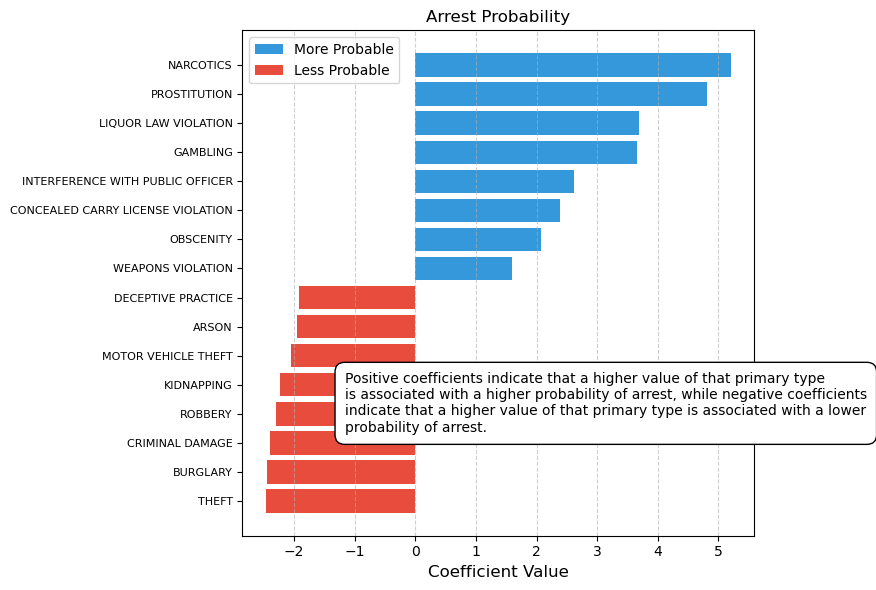

In [145]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data for top and bottom coefficients
top_coefficients = pd.Series({
    'NARCOTICS': 5.201144,
    'PROSTITUTION': 4.811505,
    'LIQUOR LAW VIOLATION': 3.697362,
    'GAMBLING': 3.656377,
    'INTERFERENCE WITH PUBLIC OFFICER': 2.610785,
    'CONCEALED CARRY LICENSE VIOLATION': 2.385768,
    'OBSCENITY': 2.073450,
    'WEAPONS VIOLATION': 1.603467
})

bottom_coefficients = pd.Series({
    'DECEPTIVE PRACTICE': -1.924606,
    'ARSON': -1.951970,
    'MOTOR VEHICLE THEFT': -2.044775,
    'KIDNAPPING': -2.232423,
    'ROBBERY': -2.300064,
    'CRIMINAL DAMAGE': -2.389572,
    'BURGLARY': -2.451464,
    'THEFT': -2.466027
})
# Separate positive and negative coefficients
positive_coefficients = combined_coefficients[combined_coefficients >= 0]
negative_coefficients = combined_coefficients[combined_coefficients < 0]

# Define colors for positive and negative coefficients
positive_colors = '#3498DB'
negative_colors = '#E74C3C'

# Create horizontal bar chart for positive coefficients
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(positive_coefficients.index, positive_coefficients, color=positive_colors)

# Create horizontal bar chart for negative coefficients
ax.barh(negative_coefficients.index, negative_coefficients, color=negative_colors)

# Add text box with information about coefficient interpretation
info_text = ("Positive coefficients indicate that a higher value of that primary type\n"
             "is associated with a higher probability of arrest, while negative coefficients\n"
             "indicate that a higher value of that primary type is associated with a lower\n"
             "probability of arrest.")
ax.text(0.2, 0.2, info_text, transform=ax.transAxes, fontsize=10, va='bottom', ha='left', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.7'))

ax.set_title('Arrest Probability', fontsize=12)  # Set title font size
ax.set_xlabel('Coefficient Value', fontsize=12)  # Set x-axis label font size

# Add legend with custom labels for positive and negative coefficients
ax.legend(['More Probable', 'Less Probable'], fontsize=10)

# Add grid lines for better readability
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Modify y-axis tick font size
plt.yticks(fontsize=8)

# Invert y-axis for better readability
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [33]:
# Filter coefficients with "Location Description" in their names
location_desc_coefs = named_coef[named_coef.index.str.contains('Location Description')]

# Sort coefficients in descending order
location_desc_coefs_sorted = location_desc_coefs.sort_values(ascending=False)

# Get the top 5 coefficients for Location Description
top_5_location_desc_coefs = location_desc_coefs_sorted.head(8)

# Get the bottom 5 coefficients for Location Description
bottom_5_location_desc_coefs = location_desc_coefs_sorted.tail(8)

# Print the top 5 and bottom 5 coefficients for Location Description
print("Top 5 coefficients for Location Description:")
print(top_5_location_desc_coefs)

print("\nBottom 5 coefficients for Location Description:")
print(bottom_5_location_desc_coefs)


Top 5 coefficients for Location Description:
Location Description_DEPARTMENT STORE                         2.414298
Location Description_GROCERY FOOD STORE                       2.133232
Location Description_DRUG STORE                               2.046086
Location Description_CTA PLATFORM                             1.954224
Location Description_OTHER RAILROAD PROP / TRAIN DEPOT        1.644516
Location Description_APPLIANCE STORE                          1.422210
Location Description_POLICE FACILITY / VEHICLE PARKING LOT    1.317393
Location Description_JAIL / LOCK-UP FACILITY                  1.258963
dtype: float64

Bottom 5 coefficients for Location Description:
Location Description_DAY CARE CENTER                     -0.886779
Location Description_CHURCH/SYNAGOGUE/PLACE OF WORSHIP   -0.934599
Location Description_COMMERCIAL / BUSINESS OFFICE        -0.941658
Location Description_SCHOOL - PUBLIC BUILDING            -1.223935
Location Description_NURSING HOME/RETIREMENT HOME      

In [34]:
named_coef = pd.Series(model.coef_[0], index=model.feature_names_in_)

print(f"Name coef: {named_coef}")

Name coef: Primary Type_ARSON                               -1.951970
Primary Type_ASSAULT                             -1.101245
Primary Type_BATTERY                             -1.108648
Primary Type_BURGLARY                            -2.451464
Primary Type_CONCEALED CARRY LICENSE VIOLATION    2.385768
                                                    ...   
Year_2019                                        -0.161354
Year_2020                                        -0.419184
Year_2021                                        -0.847301
Year_2022                                        -0.730729
Year_2023                                        -0.922480
Length: 231, dtype: float64


In [35]:

# The logistic function is used to convert the coefficients into probabilities. 
# The logistic function takes a real-valued number as input and maps it to a value between 0 and 1. 
# This is useful for representing probabilities.

# Define the logistic function
def logistic_function(x):
    return 1 / (1 + np.exp(-x))

# Filter coefficients with "Primary Type" in their names
primary_type_coefs = named_coef[named_coef.index.str.contains('Primary Type')]

# Filter coefficients with "Location Description" in their names
location_desc_coefs = named_coef[named_coef.index.str.contains('Location Description')]

# Convert coefficients to probabilities using the logistic function
primary_type_probs = logistic_function(primary_type_coefs)
location_desc_probs = logistic_function(location_desc_coefs)

# https://numpy.org/doc/stable/reference/generated/numpy.outer.html
# We use np.outer to calculate the outer product of primary_type_probs and location_desc_probs. 
# This operation creates a matrix where each element represents the product of the probability 
# of arrest for a specific Primary Type and a specific Location Description combination.
# Calculate the product of probabilities for each combination
combination_probs = np.outer(primary_type_probs, location_desc_probs)

# Find the indices that would sort the combination_probs array in descending order
sorted_indices = np.argsort(combination_probs.ravel())[::-1]

# https://numpy.org/doc/stable/reference/generated/numpy.unravel_index.html
# Find the indices of the maximum probability combination
top_ten_indices = np.unravel_index(sorted_indices[:10], combination_probs.shape)


# code creates a list of tuples representing the top ten combinations of "Primary Type" and "Location Description" with the highest probabilities.
top_ten_combinations = list(zip(primary_type_coefs.index[top_ten_indices[0]], location_desc_coefs.index[top_ten_indices[1]]))

# Print the top ten combinations and their corresponding probabilities
print("Top ten combinations and their probabilities:")
for i, (primary_type, location_desc) in enumerate(top_ten_combinations):
    probability = combination_probs[top_ten_indices[0][i], top_ten_indices[1][i]]
    print(f"{i + 1}. {primary_type} in {location_desc}: Probability = {probability}")


Top ten combinations and their probabilities:
1. Primary Type_NARCOTICS in Location Description_DEPARTMENT STORE: Probability = 0.9128809426514055
2. Primary Type_PROSTITUTION in Location Description_DEPARTMENT STORE: Probability = 0.91050365366552
3. Primary Type_LIQUOR LAW VIOLATION in Location Description_DEPARTMENT STORE: Probability = 0.8957076156780653
4. Primary Type_GAMBLING in Location Description_DEPARTMENT STORE: Probability = 0.8948020635285316
5. Primary Type_NARCOTICS in Location Description_GROCERY FOOD STORE: Probability = 0.8891917365639739
6. Primary Type_PROSTITUTION in Location Description_GROCERY FOOD STORE: Probability = 0.8868761380856726
7. Primary Type_NARCOTICS in Location Description_DRUG STORE: Probability = 0.8806986796876004
8. Primary Type_PROSTITUTION in Location Description_DRUG STORE: Probability = 0.8784051984971352
9. Primary Type_LIQUOR LAW VIOLATION in Location Description_GROCERY FOOD STORE: Probability = 0.8724640564026886
10. Primary Type_GAMBLI

In [36]:
# Data - Top ten combinations and their probabilities
combinations = [
    'Primary Type_NARCOTICS in Location Description_DEPARTMENT STORE',
    'Primary Type_PROSTITUTION in Location Description_DEPARTMENT STORE',
    'Primary Type_LIQUOR LAW VIOLATION in Location Description_DEPARTMENT STORE',
    'Primary Type_GAMBLING in Location Description_DEPARTMENT STORE',
    'Primary Type_NARCOTICS in Location Description_DRUG STORE',
    'Primary Type_NARCOTICS in Location Description_GROCERY FOOD STORE',
    'Primary Type_PROSTITUTION in Location Description_DRUG STORE',
    'Primary Type_PROSTITUTION in Location Description_GROCERY FOOD STORE',
    'Primary Type_LIQUOR LAW VIOLATION in Location Description_DRUG STORE',
    'Primary Type_LIQUOR LAW VIOLATION in Location Description_GROCERY FOOD STORE'
]
probabilities = [
    0.9186827551878766,
    0.917089976850531,
    0.9006933631898705,
    0.900061481366384,
    0.8981431413412321,
    0.897551677580911,
    0.8965859738301566,
    0.895995535527927,
    0.880555950389113,
    0.8799760685088011
]

# Create a list of lists to represent the table data
table_data = []
for i in range(len(combinations)):
    table_data.append([combinations[i], "{:.2f}".format(probabilities[i] * 100)])

# Table headers
headers = ["Combination", "Probability (%)"]

# Generate the table
table = tabulate(table_data, headers, tablefmt="grid")

# Print the table
print(table)


+------------------------------------------------------------------------------+-------------------+
| Combination                                                                  |   Probability (%) |
+==============================================================================+===================+
| Primary Type_NARCOTICS in Location Description_DEPARTMENT STORE              |             91.87 |
+------------------------------------------------------------------------------+-------------------+
| Primary Type_PROSTITUTION in Location Description_DEPARTMENT STORE           |             91.71 |
+------------------------------------------------------------------------------+-------------------+
| Primary Type_LIQUOR LAW VIOLATION in Location Description_DEPARTMENT STORE   |             90.07 |
+------------------------------------------------------------------------------+-------------------+
| Primary Type_GAMBLING in Location Description_DEPARTMENT STORE               |           

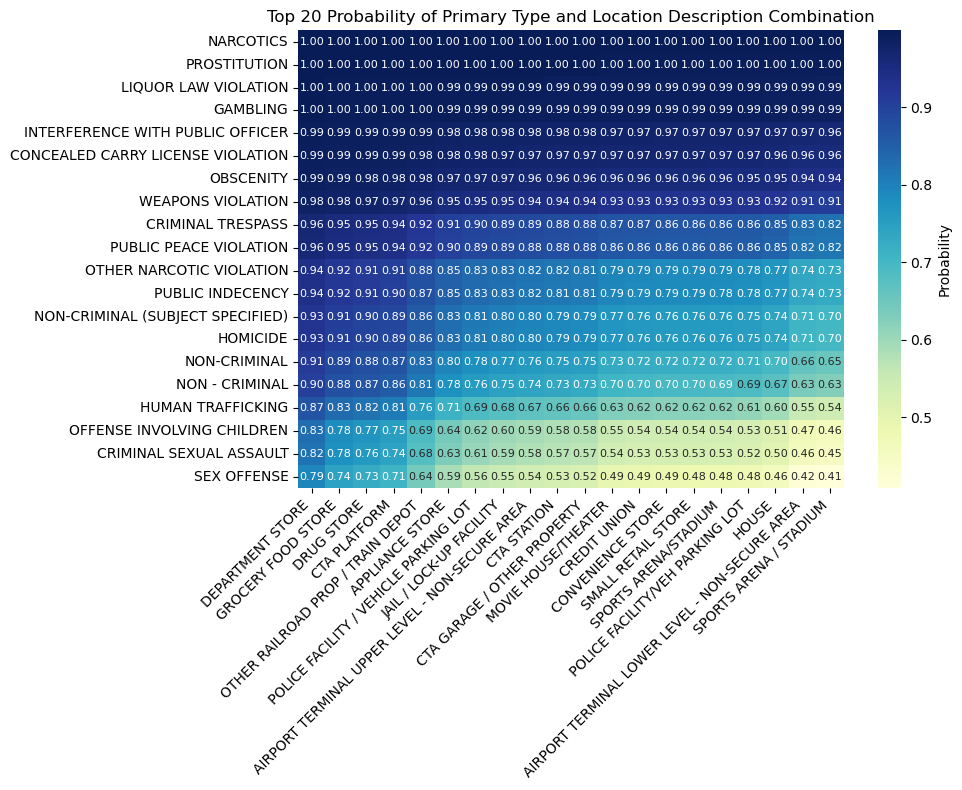

In [37]:
# Sort the coefficients for Primary Type and Location Description in descending order
sorted_primary_type_coefs = primary_type_coefs.sort_values(ascending=False)[:20]
sorted_location_desc_coefs = location_desc_coefs.sort_values(ascending=False)[:20]

# Remove the prefix from the index labels
sorted_primary_type_coefs.index = [label.split('_')[1] for label in sorted_primary_type_coefs.index]
sorted_location_desc_coefs.index = [label.split('_')[1] for label in sorted_location_desc_coefs.index]

# Create a DataFrame to hold the probability values for each combination
probabilities_df = pd.DataFrame(index=sorted_primary_type_coefs.index, columns=sorted_location_desc_coefs.index)

# Calculate the probability for each combination and store it in the DataFrame
for primary_type in sorted_primary_type_coefs.index:
    for location_desc in sorted_location_desc_coefs.index:
        probability = logistic_function(sorted_primary_type_coefs[primary_type] + sorted_location_desc_coefs[location_desc])
        probabilities_df.loc[primary_type, location_desc] = probability

# Convert probability values to numeric
probabilities_df = probabilities_df.apply(pd.to_numeric)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(probabilities_df, cmap='YlGnBu', annot=True, fmt='.2f', cbar_kws={'label': 'Probability'}, annot_kws={'fontsize': 8})
plt.xticks(rotation=45, ha='right')
# plt.xlabel('Location Description')
# plt.ylabel('Primary Type')
plt.title('Top 20 Probability of Primary Type and Location Description Combination')
plt.tight_layout()
plt.show()




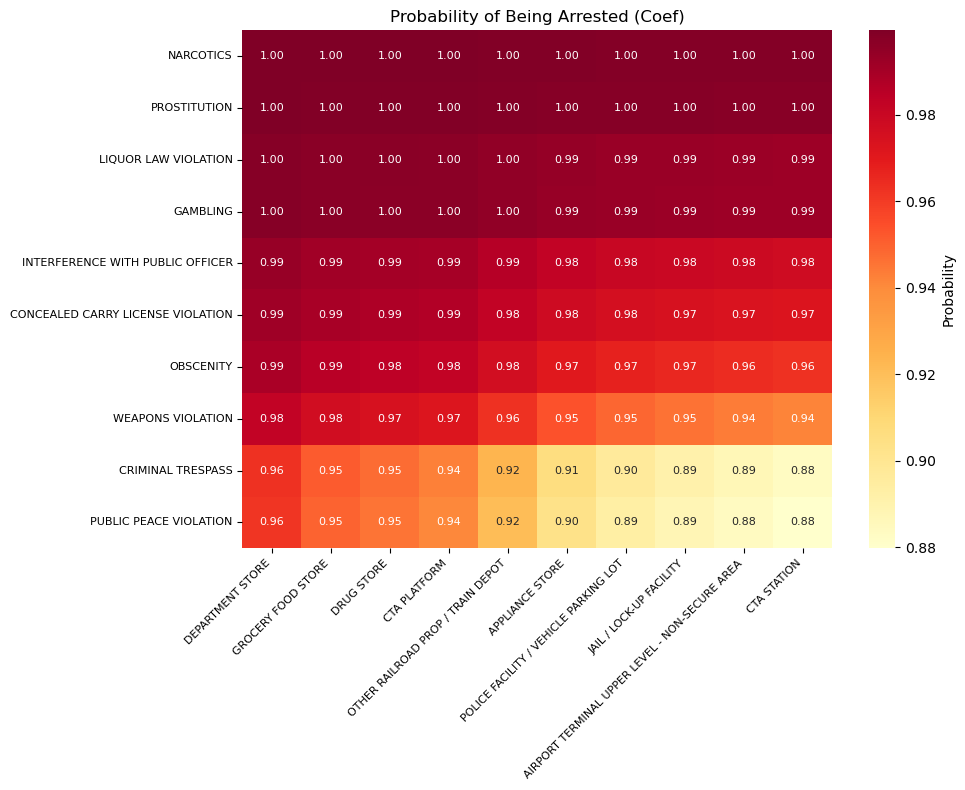

In [38]:
# Sort the coefficients for Primary Type and Location Description in descending order
sorted_primary_type_coefs = primary_type_coefs.sort_values(ascending=False)[:10]
sorted_location_desc_coefs = location_desc_coefs.sort_values(ascending=False)[:10]

# Remove the prefix from the index labels
sorted_primary_type_coefs.index = [label.split('_')[1] for label in sorted_primary_type_coefs.index]
sorted_location_desc_coefs.index = [label.replace('Location Description_', '') for label in sorted_location_desc_coefs.index]

# Create a DataFrame to hold the probability values for each combination
probabilities_df = pd.DataFrame(index=sorted_primary_type_coefs.index, columns=sorted_location_desc_coefs.index)

# Calculate the probability for each combination and store it in the DataFrame
for primary_type in sorted_primary_type_coefs.index:
    for location_desc in sorted_location_desc_coefs.index:
        probability = logistic_function(sorted_primary_type_coefs[primary_type] + sorted_location_desc_coefs[location_desc])
        probabilities_df.loc[primary_type, location_desc] = probability

# Convert probability values to numeric
probabilities_df = probabilities_df.apply(pd.to_numeric)

# Create the heatmap with the "YlOrRd" colormap
plt.figure(figsize=(10, 8))
sns.heatmap(probabilities_df, cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Probability'}, annot_kws={'fontsize': 8})
plt.xticks(rotation=45, ha='right', fontsize=8)  # Set x-axis label font size
plt.yticks(fontsize=8)  # Set y-axis label font size


# plt.xlabel('Location Description', fontsize=10)  # Set x-axis label and its font size
# plt.ylabel('Primary Type', fontsize=10)  # Set y-axis label and its font size
plt.title('Probability of Being Arrested (Coef)', fontsize=12)  # Set title and its font size
plt.tight_layout()
plt.show()


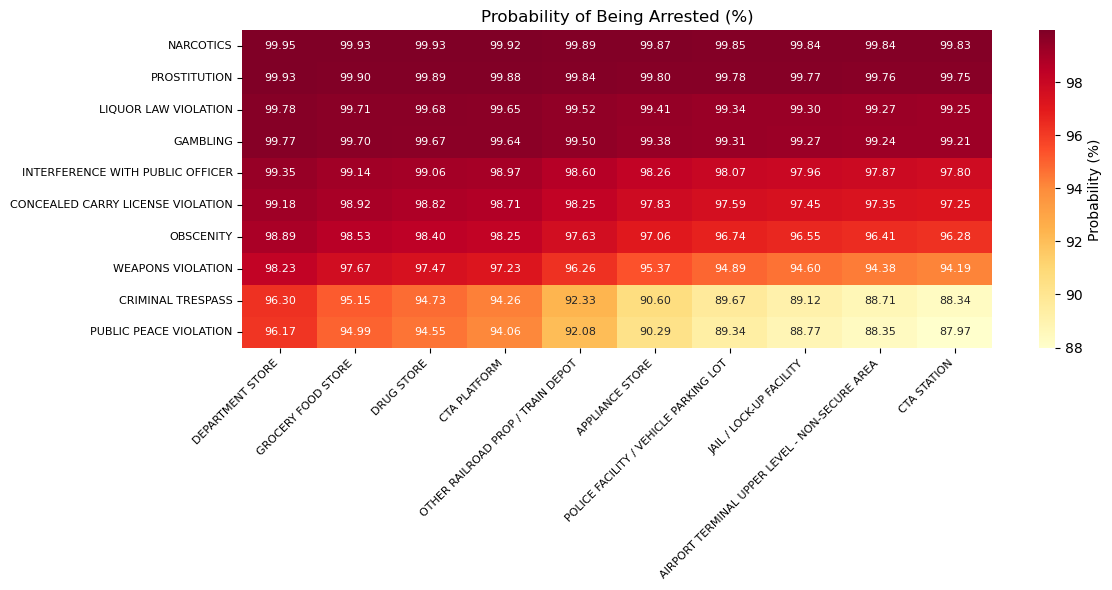

In [39]:
# Define the logistic function to convert coefficients to probabilities
def logistic_function(coef):
    return 1 / (1 + np.exp(-coef))

# Sort the coefficients for Primary Type and Location Description in descending order
sorted_primary_type_coefs = primary_type_coefs.sort_values(ascending=False)[:10]
sorted_location_desc_coefs = location_desc_coefs.sort_values(ascending=False)[:10]

# Remove the prefix from the index labels
sorted_primary_type_coefs.index = [label.split('_')[1] for label in sorted_primary_type_coefs.index]
sorted_location_desc_coefs.index = [label.replace('Location Description_', '') for label in sorted_location_desc_coefs.index]

# Create a DataFrame to hold the probability values (as percentages) for each combination
probabilities_df = pd.DataFrame(index=sorted_primary_type_coefs.index, columns=sorted_location_desc_coefs.index)

# Calculate the probability (as percentages) for each combination and store it in the DataFrame
for primary_type in sorted_primary_type_coefs.index:
    for location_desc in sorted_location_desc_coefs.index:
        probability = logistic_function(sorted_primary_type_coefs[primary_type] + sorted_location_desc_coefs[location_desc]) * 100
        probabilities_df.loc[primary_type, location_desc] = probability

# Convert probability values to numeric
probabilities_df = probabilities_df.apply(pd.to_numeric)

# Create the heatmap with the "YlOrRd" colormap
plt.figure(figsize=(12, 6))
sns.heatmap(probabilities_df, cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Probability (%)'}, annot_kws={'fontsize': 8})
plt.xticks(rotation=45, ha='right', fontsize=8)  # Set x-axis label font size
plt.yticks(fontsize=8)  # Set y-axis label font size

# plt.xlabel('Location Description', fontsize=10)  # Set x-axis label and its font size
# plt.ylabel('Primary Type', fontsize=10)  # Set y-axis label and its font size
plt.title('Probability of Being Arrested (%)', fontsize=12)  # Set title and its font size
plt.tight_layout()
plt.show()


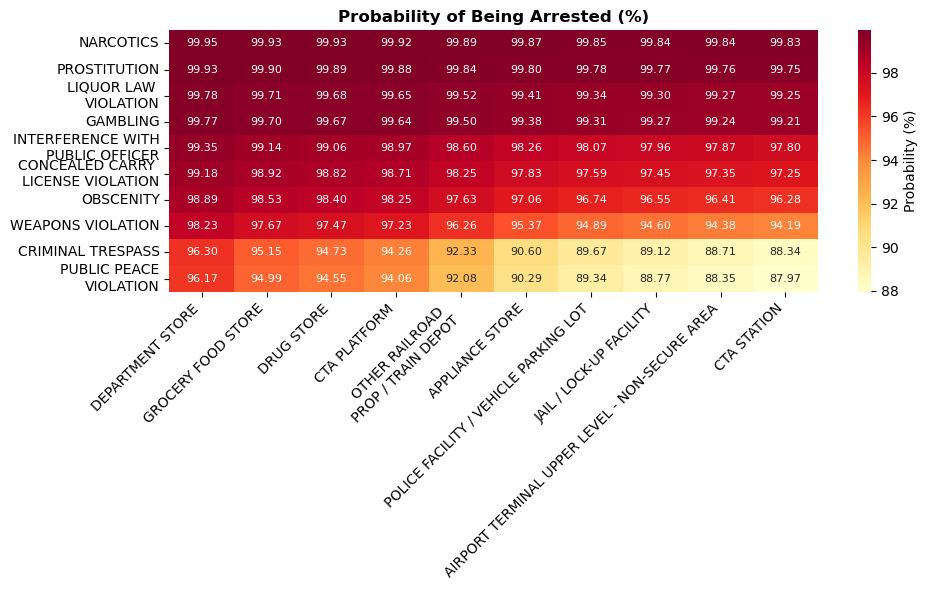

In [40]:
# Define the logistic function to convert coefficients to probabilities
def logistic_function(coef):
    return 1 / (1 + np.exp(-coef))

# Sort the coefficients for Primary Type and Location Description in descending order
sorted_primary_type_coefs = primary_type_coefs.sort_values(ascending=False)[:10]
sorted_location_desc_coefs = location_desc_coefs.sort_values(ascending=False)[:10]

# Remove the prefix from the index labels
sorted_primary_type_coefs.index = [label.split('_')[1] for label in sorted_primary_type_coefs.index]
sorted_location_desc_coefs.index = [label.replace('Location Description_', '') for label in sorted_location_desc_coefs.index]

# Create a DataFrame to hold the probability values (as percentages) for each combination
probabilities_df = pd.DataFrame(index=sorted_primary_type_coefs.index, columns=sorted_location_desc_coefs.index)

# Calculate the probability (as percentages) for each combination and store it in the DataFrame
for primary_type in sorted_primary_type_coefs.index:
    for location_desc in sorted_location_desc_coefs.index:
        probability = logistic_function(sorted_primary_type_coefs[primary_type] + sorted_location_desc_coefs[location_desc]) * 100
        probabilities_df.loc[primary_type, location_desc] = probability

# Convert probability values to numeric
probabilities_df = probabilities_df.apply(pd.to_numeric)

# Create the heatmap with the "YlOrRd" colormap
plt.figure(figsize=(10, 6))
sns.heatmap(probabilities_df, cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Probability (%)'}, annot_kws={'fontsize': 8})

# Modify x-axis labels for two lines
x_tick_labels = [label.replace('OTHER RAILROAD PROP / TRAIN DEPOT', 'OTHER RAILROAD \nPROP / TRAIN DEPOT') if len(label) > 10 else label for label in probabilities_df.columns]
x_tick_labels = [label.replace('CTA GARAGE / OTHER PROPERTY', 'CTA GARAGE /\nOTHER PROPERTY') if len(label) > 10 else label for label in x_tick_labels]
x_tick_labels = [label.replace('AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA', 'AIRPORT TERMINAL LOWER \nLEVEL - NON-SECURE AREA') if len(label) > 10 else label for label in x_tick_labels]# Use x_tick_labels here, not probabilities_df.columns
plt.xticks(ticks=plt.xticks()[0], labels=x_tick_labels, rotation=45, ha='right', fontsize=10)

# Modify y-axis labels for two lines
y_tick_labels = [label.replace('INTERFERENCE WITH PUBLIC OFFICER', 'INTERFERENCE WITH\nPUBLIC OFFICER') if label == 'INTERFERENCE WITH PUBLIC OFFICER' else label for label in probabilities_df.index]
y_tick_labels = [label.replace('PUBLIC PEACE VIOLATION', 'PUBLIC PEACE\nVIOLATION') if label == 'PUBLIC PEACE VIOLATION' else label for label in y_tick_labels]
y_tick_labels = [label.replace('CONCEALED CARRY LICENSE VIOLATION', 'CONCEALED CARRY \nLICENSE VIOLATION') if label == 'CONCEALED CARRY LICENSE VIOLATION' else label for label in y_tick_labels]
y_tick_labels = [label.replace('LIQUOR LAW VIOLATION', 'LIQUOR LAW \nVIOLATION') if label == 'LIQUOR LAW VIOLATION' else label for label in y_tick_labels]
plt.yticks(ticks=plt.yticks()[0], labels=y_tick_labels, fontsize=10)

# plt.xlabel('Location Description', fontsize=10)  # Set x-axis label and its font size
# plt.ylabel('Primary Type', fontsize=10)  # Set y-axis label and its font size
plt.title('Probability of Being Arrested (%)', fontsize=12, weight='bold')  
plt.tight_layout()
plt.show()



In [41]:
# identify all primary types and divide by the total number times with arrest=y vs total number of times primary type shows up

### Null Hypothesis: We believe that arrest rate is equal against all crimes
### Alt: There is an unequal arrest rate among differnt crimes

##### Multiple Linear Regression With scikit-learn

In [42]:
# Source: https://realpython.com/linear-regression-in-python/

# Step 1: Import packages and classes (DONE)
# Step 2: Provide data
x = df_encoded.drop('Arrest', axis=1)
y = df_encoded['Arrest']
x, y = np.array(x), np.array(y)



In [43]:
# Print x to see how it looks
x

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [44]:
# Print y to see how it looks
y

array([False, False, False, ..., False, False, False])

In [45]:
# In multiple linear regression, x is a two-dimensional array with at least two columns, 
# while y is usually a one-dimensional array. 
# This is a simple example of multiple linear regression, and x has exactly two columns.

In [46]:
# Step 3: Create a model and fit it
model = LinearRegression().fit(x, y)

In [47]:
# Step 4: Get results
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")

coefficient of determination: 0.4759121409987759
intercept: 503676667817.3279
coefficients: [ 4.07725179e+09  4.07725179e+09  4.07725179e+09  4.07725179e+09
  4.07725179e+09  4.07725179e+09  4.07725179e+09  4.07725179e+09
  4.07725179e+09  4.07725179e+09  4.07725179e+09  4.07725179e+09
  4.07725179e+09  4.07725179e+09  4.07725179e+09  4.07725179e+09
  4.07725179e+09  4.07725179e+09  4.07725179e+09  4.07725179e+09
  4.07725179e+09  4.07725179e+09  4.07725179e+09  4.07725179e+09
  4.07725179e+09  4.07725179e+09  4.07725179e+09  4.07725179e+09
  4.07725179e+09  4.07725179e+09  4.07725179e+09  4.07725179e+09
  4.07725179e+09  4.07725179e+09  1.44517183e-01 -3.49412560e-02
  1.82483792e-01  1.50083661e-01  2.43387520e-01  2.08245844e-01
  2.38401532e-01 -3.46685275e-02  5.98661900e-02  3.38039935e-01
  1.11772858e-01  9.11301710e-02  3.19463462e-02  1.00690611e-01
  1.10351920e-01 -4.43548933e-02  6.76467419e-02  3.76054823e-01
  2.01646090e-02 -1.56717300e-02 -6.35038614e-02  1.45683520e-0

### Split arrays or matrices into random train and test subsets

In [48]:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X, y = np.arange(10).reshape((5, 2)), range(5)
print(f"X: {X}")

print(f"y array:")
list(y)

X: [[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
y array:


[0, 1, 2, 3, 4]

In [49]:
# Source: https://realpython.com/train-test-split-python-data/

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

print(f"X_train:")
print(X_train)

print(f"y_train:")
print(y_train)

print(f"X_test:")
print(X_test)

print(f"y_test:")
print(y_test)


X_train:
[[4 5]
 [0 1]
 [6 7]]
y_train:
[2, 0, 3]
X_test:
[[2 3]
 [8 9]]
y_test:
[1, 4]


In [50]:
train_test_split(y, shuffle=False)

[[0, 1, 2], [3, 4]]

In [51]:
df_encoded

,Arrest,Primary Type_ARSON,Primary Type_ASSAULT,Primary Type_BATTERY,Primary Type_BURGLARY,Primary Type_CONCEALED CARRY LICENSE VIOLATION,Primary Type_CRIM SEXUAL ASSAULT,Primary Type_CRIMINAL DAMAGE,Primary Type_CRIMINAL SEXUAL ASSAULT,Primary Type_CRIMINAL TRESPASS,...,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,Year_2023
1387037,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
6292945,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6783275,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4381716,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1557483,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6453382,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3387494,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
875130,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
5982238,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


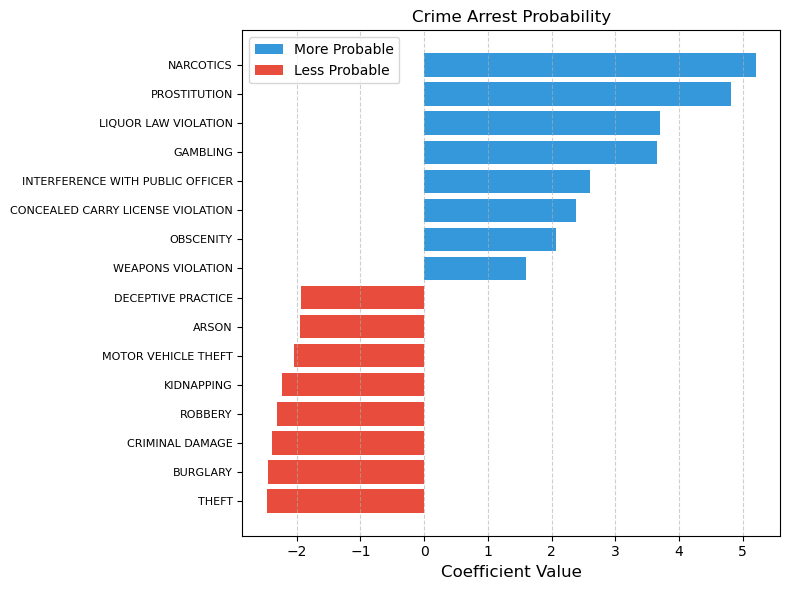

In [229]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data for top and bottom coefficients
top_coefficients = pd.Series({
    'NARCOTICS': 5.201144,
    'PROSTITUTION': 4.811505,
    'LIQUOR LAW VIOLATION': 3.697362,
    'GAMBLING': 3.656377,
    'INTERFERENCE WITH PUBLIC OFFICER': 2.610785,
    'CONCEALED CARRY LICENSE VIOLATION': 2.385768,
    'OBSCENITY': 2.073450,
    'WEAPONS VIOLATION': 1.603467
})

bottom_coefficients = pd.Series({
    'DECEPTIVE PRACTICE': -1.924606,
    'ARSON': -1.951970,
    'MOTOR VEHICLE THEFT': -2.044775,
    'KIDNAPPING': -2.232423,
    'ROBBERY': -2.300064,
    'CRIMINAL DAMAGE': -2.389572,
    'BURGLARY': -2.451464,
    'THEFT': -2.466027
})
# Separate positive and negative coefficients
positive_coefficients = combined_coefficients[combined_coefficients >= 0]
negative_coefficients = combined_coefficients[combined_coefficients < 0]

# Define colors for positive and negative coefficients
positive_colors = '#3498DB'
negative_colors = '#E74C3C'

# Create horizontal bar chart for positive coefficients
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(positive_coefficients.index, positive_coefficients, color=positive_colors)

# Create horizontal bar chart for negative coefficients
ax.barh(negative_coefficients.index, negative_coefficients, color=negative_colors)

# Add text box with information about coefficient interpretation

# Troubleshooting Tips: Because I could not figure out how to change the dimensions
# of the box, I finally, after 2 hours of hair pulling research and trial and error
# came to the brilliant idea to just put a \n. MIND BLOWN!!!! 
# info_text = ("POSITIVE coefficients indicate that a higher \nprobablity of that crime"
#              "is associated with \na higher probability of arrest." 
#              "\n\nNEGATIVE coefficients indicate that a higher \nvalue of that crime" 
#              "is associated with \na lower probability of arrest.")
# ax.text(
#     0.4,             # X-coordinate of the text position (given in axes coordinates)
#     0.2,             # Y-coordinate of the text position (given in axes coordinates)
#     info_text,       # The text content to be displayed
#     transform=ax.transAxes,  # The coordinate transformation to use (in this case, axes coordinates)
#     fontsize=9,     # Font size of the text
#     va='bottom',     # Vertical alignment of the text ('bottom' aligns the bottom of the text)
#     ha='left',       # Horizontal alignment of the text ('left' aligns the left side of the text)
#     bbox=dict(       # A dictionary defining the properties of the text box (bounding box)
#         boxstyle='round,pad=0.7',  # Style of the text box (square with padding)
#         facecolor='white',    # Color of the background of the text box
#         edgecolor='black',    # Color of the border of the text box
#     )
# )

ax.set_title('Crime Arrest Probability', fontsize=12)  # Set title font size
ax.set_xlabel('Coefficient Value', fontsize=12)  # Set x-axis label font size

# Add legend with custom labels for positive and negative coefficients
ax.legend(['More Probable', 'Less Probable'], fontsize=10)

# Add grid lines for better readability
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Modify y-axis tick font size
plt.yticks(fontsize=8)

# Invert y-axis for better readability
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


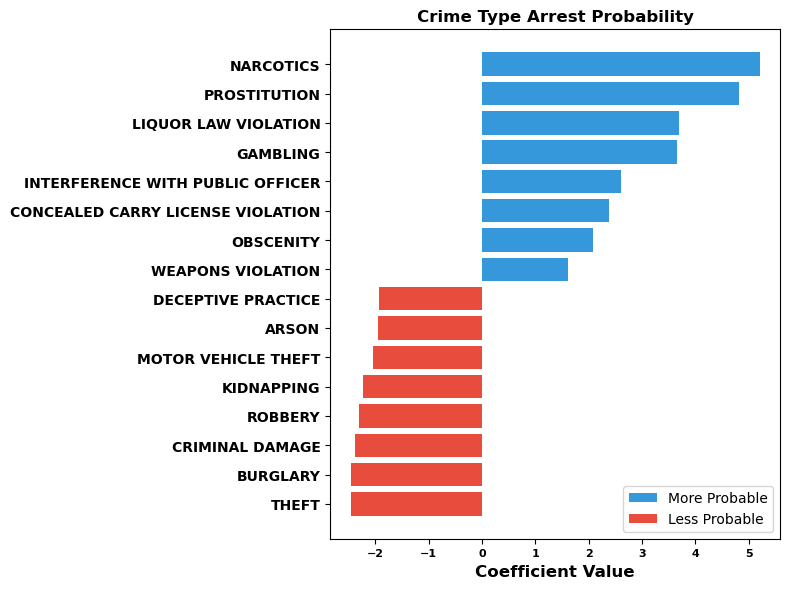

In [246]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data for top and bottom coefficients
top_coefficients = pd.Series({
    'NARCOTICS': 5.201144,
    'PROSTITUTION': 4.811505,
    'LIQUOR LAW VIOLATION': 3.697362,
    'GAMBLING': 3.656377,
    'INTERFERENCE WITH PUBLIC OFFICER': 2.610785,
    'CONCEALED CARRY LICENSE VIOLATION': 2.385768,
    'OBSCENITY': 2.073450,
    'WEAPONS VIOLATION': 1.603467
})

bottom_coefficients = pd.Series({
    'DECEPTIVE PRACTICE': -1.924606,
    'ARSON': -1.951970,
    'MOTOR VEHICLE THEFT': -2.044775,
    'KIDNAPPING': -2.232423,
    'ROBBERY': -2.300064,
    'CRIMINAL DAMAGE': -2.389572,
    'BURGLARY': -2.451464,
    'THEFT': -2.466027
})

# Separate positive and negative coefficients
positive_coefficients = top_coefficients[top_coefficients >= 0]
negative_coefficients = bottom_coefficients[bottom_coefficients < 0]

# Define colors for positive and negative coefficients
positive_color = '#3498DB'
negative_color = '#E74C3C'

# Create horizontal bar chart for positive coefficients
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(positive_coefficients.index, positive_coefficients, color=positive_color)

# Create horizontal bar chart for negative coefficients
ax.barh(negative_coefficients.index, negative_coefficients, color=negative_color)

ax.set_title('Crime Type Arrest Probability', fontsize=12, weight='bold')  # Set title font size
ax.set_xlabel('Coefficient Value', fontsize=12, weight='bold')  # Set x-axis label font size

# Add legend with custom labels for positive and negative coefficients
ax.legend(['More Probable', 'Less Probable'], fontsize=10, loc='lower right')

# Add grid lines
# ax.grid(axis='x', linestyle='--', alpha=0.6)
# ax.grid(axis='y', linestyle='--', alpha=0.6)

# Modify y-axis tick font size
plt.yticks(fontsize=10, weight='bold')
plt.xticks(fontsize=8, weight='bold')

# Invert y-axis for better readability
plt.gca().invert_yaxis()


# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()


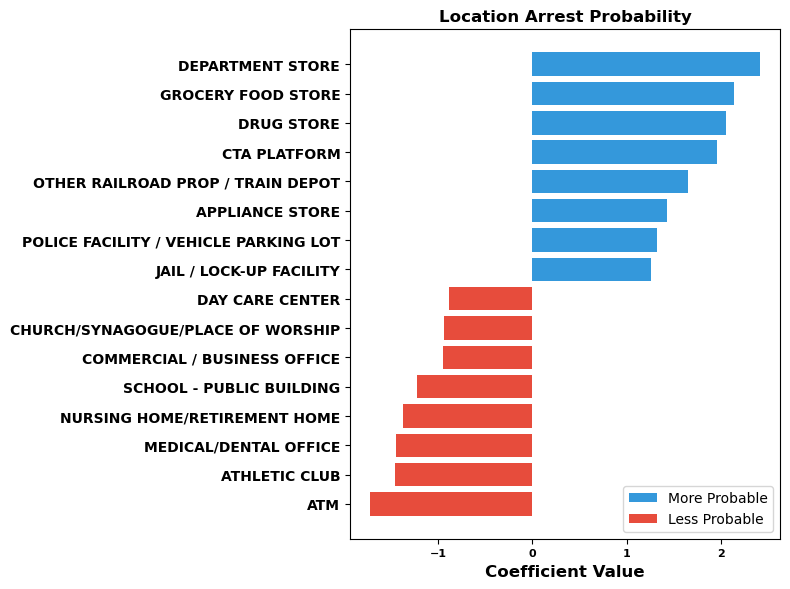

In [247]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data for top and bottom coefficients
top_coefficients_loc = pd.Series({
    'DEPARTMENT STORE': 2.414298,
    'GROCERY FOOD STORE': 2.133232,
    'DRUG STORE': 2.046086,
    'CTA PLATFORM': 1.954224,
    'OTHER RAILROAD PROP / TRAIN DEPOT': 1.644516,
    'APPLIANCE STORE': 1.422210,
    'POLICE FACILITY / VEHICLE PARKING LOT': 1.317393,
    'JAIL / LOCK-UP FACILITY': 1.258963
})

bottom_coefficients_loc = pd.Series({
    'DAY CARE CENTER': -0.886779,
    'CHURCH/SYNAGOGUE/PLACE OF WORSHIP': -0.934599,
    'COMMERCIAL / BUSINESS OFFICE': -0.941658,
    'SCHOOL - PUBLIC BUILDING': -1.223935,
    'NURSING HOME/RETIREMENT HOME': -1.364570,
    'MEDICAL/DENTAL OFFICE': -1.443343,
    'ATHLETIC CLUB': -1.457046,
    'ATM': -1.723996
})

# Separate positive and negative coefficients
positive_coefficients_loc = top_coefficients_loc[top_coefficients_loc >= 0]
negative_coefficients_loc = bottom_coefficients_loc[bottom_coefficients_loc < 0]

# Define colors for positive and negative coefficients
positive_color = '#3498DB'
negative_color = '#E74C3C'

# Create horizontal bar chart for positive coefficients
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(positive_coefficients_loc.index, positive_coefficients_loc, color=positive_color)

# Create horizontal bar chart for negative coefficients
ax.barh(negative_coefficients_loc.index, negative_coefficients_loc, color=negative_color)

ax.set_title('Location Arrest Probability', fontsize=12, weight='bold')  # Set title font size
ax.set_xlabel('Coefficient Value', fontsize=12, weight='bold')  # Set x-axis label font size

# Add legend with custom labels for positive and negative coefficients
ax.legend(['More Probable', 'Less Probable'], fontsize=10, loc='lower right')

# Add grid lines
# ax.grid(axis='x', linestyle='--', alpha=0.6)
# ax.grid(axis='y', linestyle='--', alpha=0.6)

# Modify y-axis tick font size
plt.yticks(fontsize=10, weight='bold')
plt.xticks(fontsize=8, weight='bold')

# Invert y-axis for better readability
plt.gca().invert_yaxis()


# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()
